# Part 3 Solutions Notebook

## Introduction

Linen is a sustainable fabric made from cellulosic fibers derived from the stem of the flax plant.<sup>1</sup> Both the fabric and the fibers are named as linen. Linen fibers are much stronger (two to three times) than coton fibers and they dry at a much faster rate yielding cool, absorbent fabrics.<sup>2</sup> Due to its porous nature, linen is a good heat conductor and widely preferred for clothing and bedding in the summer.<sup>2</sup>

Linen is used heavily in clothing like dresses, suits, skirts etc. and in home fashion products like curtains, sheets and towels. Detection of defective end-products is highly valuable to manufacturers in those industries and human centered detection methods are highly costly and open to lots of flaws. In offline quality control method, one of the generally used methods, production is stopped to take samples of the product and carry out the tests.<sup>3</sup> Since the production stops for each sample, the cost of monitoring the process increases. Sophisticated quality control using advanced image processing techniques would significantly improve detection and provide manufacturers with enough time to adjust their processes with a lower cost.

Also, laundries, textile manufacturers, or chemical vendors may encounter with undesired outcomes in the wash process if the monitoring and process control of linen is not properly performed during the production.<sup>4</sup>

## Background Information

For the further steps of this project, a literature review regarding the quality control for linen products could include what is considered a defect in a fabric and how to detect them through image processing. In this part of the report, both of those points will be elaborated by a number of past and concurrent studies.

The essential types of defects on a fabric for most manufacturers are warp or weft threads, oil stains and holes <sup>5</sup>. A missing thread in warp or weft is the irregularity of the texture in some specific parts of the fabric, which is the case for most of the linen images to be inspected in this project. Oil stains is another common flaw in the fabrics resulting from the lube applied to the textile machines. Lastly, the “void areas” on a fabric is also a defect stemming from the frictions during the displacement of the fabric roll <sup>5</sup>.

As to the image processing, greyscale filtering and binarization seem to be a widely used technique. Binarization simply means determining a threshold for the grey-scaled image and labelling the pixels to either one or zero, meaning white and black <sup>6</sup>. To determine a threshold, eyeballing on the histogram could be a naive method to implement <sup>8</sup>. Alternatively, a number of advanced methods namely, clustering, interclass variance and entropy are mentioned in some related articles <sup>6</sup>. After the binarization, some extra modifications to create an image consisting of larger white and black regions, in other words, to eliminate trivially small white areas, can also be applied for better results <sup>8</sup>.  

After the filtering and modification of the image, most of the studies focuses on data mining techniques for detection and classification of defects. Semi-algebraic networks is the method used in the conference paper of Blaga M. to identify defective and non-defective areas <sup>8</sup>, whereas, a modified version of K-means clustering is applied in the study of Jeong. S <sup>8</sup>. A totally algebraic approach without data mining techniques in the detection of defects can be found on the paper of Mohamed Jmali<sup>5</sup>. From white and black intensities in the sections of binarized image and the differences of number of white and black pixels in the adjacent rows, three different but similar methods are presented for three types of defects.  When it comes to the classification of the defects, neural networks and fuzzy c-means algorithms are deployed in the articles of Jmali <sup>5</sup> and Jeong S. <sup>7</sup>.

## Approach

The following libraries will be used in this part.

In [537]:
from PIL import Image, ImageFilter
import matplotlib.pyplot as plt
import numpy as np
from sklearn.feature_extraction.image import extract_patches_2d

Function used to get the patches from the original image:

In [63]:
def getPatches(pixel_array, window_shape, step_length):
    edge_size = pixel_array.shape[0]
    whole_data = extract_patches_2d(pixel_array, window_shape)
    last_patch_index = edge_size - window_shape[0]
    indices = np.array(range(0,last_patch_index,step_length))
    desired_patch_indices = np.array([])
    for i in indices:
        desired_patch_indices = np.concatenate((desired_patch_indices, indices + i*last_patch_index))
    desired_patch_indices = np.array(desired_patch_indices, dtype="int32")
    patches = whole_data[desired_patch_indices]
    return patches

Function used to get the pixel ratios of image and patches with a given number of bins:

In [35]:
def getPixelRatios(pixel_array, bin_number):
    bin_size = int(256 / bin_number)
    shape = pixel_array.shape
    if len(shape) == 2:
        # then image itself is given
        flattened = pixel_array.reshape((1,-1))
    elif len(shape) == 3:
        # then patches data is given
        flattened = pixel_array.reshape((shape[0],-1))
    else:
        print("Wrong array shape")
        return
    range_data = np.array(flattened / bin_size, dtype="int32")
    pixel_freqs = np.apply_along_axis(lambda arr: np.bincount(arr, minlength=bin_number), arr=range_data, axis=1)
    pixel_ratios = pixel_freqs / flattened.shape[1]
    return pixel_ratios

Function used to plot pixel ratios of the image:

In [36]:
def plotPixelRatios(pixel_ratios):
    plt.figure()
    plt.plot(pixel_ratios)
    plt.title("Pixel ratios of the original picture")
    plt.xlabel("Bin number")
    plt.ylabel("Pixel ratio")
    plt.show()

Function used to draw the X-bar chart for pixel ratios of patches:

In [453]:
def calculateBinLimits(patch_ratios, sigmalevel=3):
    xbarbar = patch_ratios.mean(axis=0)
    sigma = patch_ratios.std(axis=0)
    sigma[xbarbar <= 0.001] *= 2
    upper_limit = xbarbar + sigmalevel * sigma
    lower_limit = xbarbar - sigmalevel * sigma
    lower_limit[lower_limit < 0] = 0
    #upper_limit[xbarbar <= 0.001] *= 2
    return (xbarbar, upper_limit, lower_limit, sigma)

In [716]:
def getOutlierPatchIndices(pixel_ratios, bin_limits, window_shape, step_length, bin_number):
    patch_number = int((512-window_shape[0])/step_length)**2
    outlier_score=np.zeros((patch_number,bin_number))

    for bin_no in range(bin_number):
        bin_density = pixel_ratios[:,bin_no]
        outlier_indices_up=np.where(bin_density > bin_limits[1][bin_no])[0]
        outlier_score[outlier_indices_up, bin_no] += (pixel_ratios[outlier_indices_up, bin_no] - bin_limits[1][bin_no]) / bin_limits[3][bin_no]
        outlier_indices_down = np.where( bin_density < bin_limits[2][bin_no] )[0]
        outlier_score[outlier_indices_down, bin_no] += (bin_limits[2][bin_no] - pixel_ratios[outlier_indices_down, bin_no]) / bin_limits[3][bin_no]
    sum_score = np.sum(outlier_score, axis=1)
    indices = np.where(sum_score > 2)[0]
    return (indices, sum_score[indices])

In [303]:
def plotXBarChart(patch_ratios, bin_limits, figsize=[16,20]):
    xbarbar = bin_limits[0]
    upper_limit = bin_limits[1]
    lower_limit = bin_limits[2]

    bin_number = patch_ratios.shape[1]
    plt.figure(figsize=figsize)
    for i in range(bin_number):
        plt.subplot(bin_number/2,2,i+1)
        plt.title("Pixel Ratio X-Bar Chart - Bin #{0}".format(i))
        plt.xlabel('Patch number')
        plt.ylabel('Pixel Ratio (X-Bar)')
        plt.plot(patch_ratios[:,i])
        plt.axhline(upper_limit[i],color="r", linestyle='--', label='UCL/LCL')
        plt.axhline(lower_limit[i],color="r", linestyle='--')
        plt.axhline(xbarbar[i],color="g", label='CL')
        plt.legend()
        plt.tight_layout()
    plt.show()

In [399]:
def fillOutliers(image, outlier_patch_infos, window_shape, step_length, figsize=[10,16], alpha=0.15):
    total_patch_in_row = int( (image.shape[0] - window_shape[0]) / step_length ) + 1
    outlier_patch_indices = outlier_patch_infos[0]
    plt.figure(figsize=figsize)
    plt.subplot(1,2,1)
    plt.imshow(image)
    plt.tight_layout()
    plt.subplot(1,2,2)
    plt.imshow(image)
    origin_x = ( outlier_patch_indices % total_patch_in_row ) * step_length
    origin_y = np.array((outlier_patch_indices / total_patch_in_row) * step_length, dtype='uint32')
    for i in range(len(outlier_patch_indices)):
        corner_xs = [origin_x[i],
                  origin_x[i]+window_shape[0],
                  origin_x[i]+window_shape[0],
                  origin_x[i]]
        corner_ys = [origin_y[i],
                  origin_y[i],
                  origin_y[i]+window_shape[0],
                  origin_y[i]+window_shape[0]]
        plt.fill(corner_xs, corner_ys, 'r', alpha=min(1,alpha * outlier_patch_infos[1][i]))
    plt.tight_layout()
    plt.show()

Some constants used in the functions:

In [305]:
window_shape = (24, 24)
step_length = 8
bin_number = 16
plt.gray()

<Figure size 432x288 with 0 Axes>

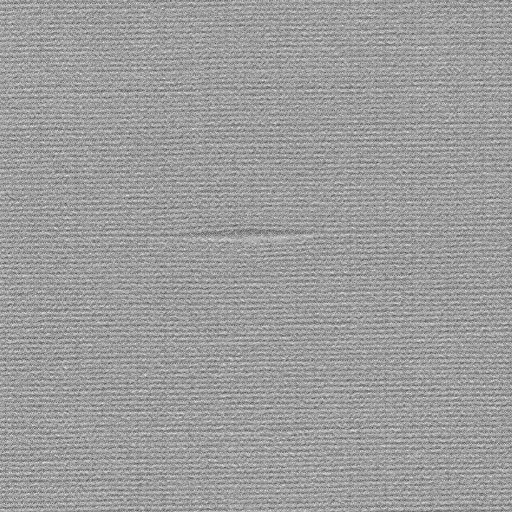

In [334]:
img1 =Image.open("Images/Fabric14.jpg").convert('L')
img1

In [335]:
pix1 = np.array(img1)
patches1 = getPatches(pix1, window_shape, step_length)
patches1.shape

(3721, 24, 24)

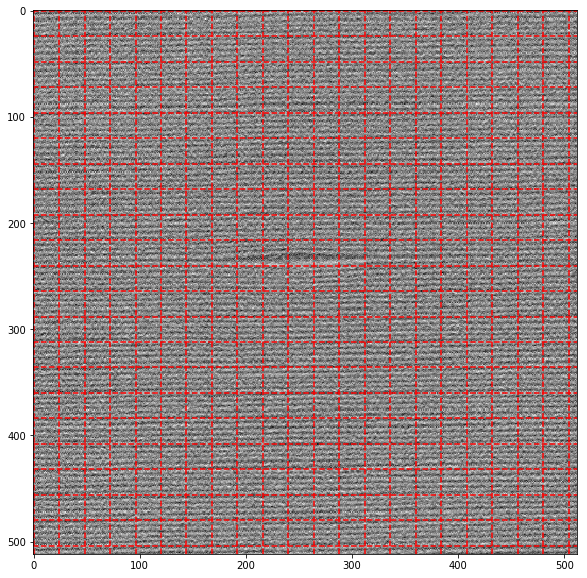

In [336]:
plt.figure(figsize=[10,10])
plt.imshow(pix1)
for i in range(0,512,24):
    plt.axhline(i,color="r", linestyle='--')
    plt.axvline(i, color="r", linestyle='--')
plt.show()

In [337]:
img1_pixel_ratios = getPixelRatios(pix1, bin_number).reshape((-1,))
patch1_pixel_ratios = getPixelRatios(patches1, bin_number)

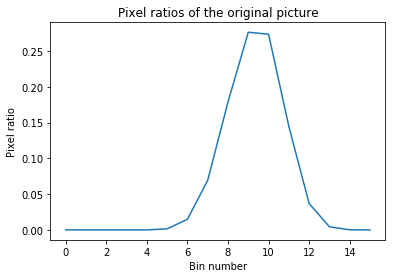

In [338]:
plotPixelRatios(img1_pixel_ratios)

In [339]:
patch1_pixel_ratios.shape

(3721, 16)

In [360]:
image1_bin_limits = calculateBinLimits(patch1_pixel_ratios)

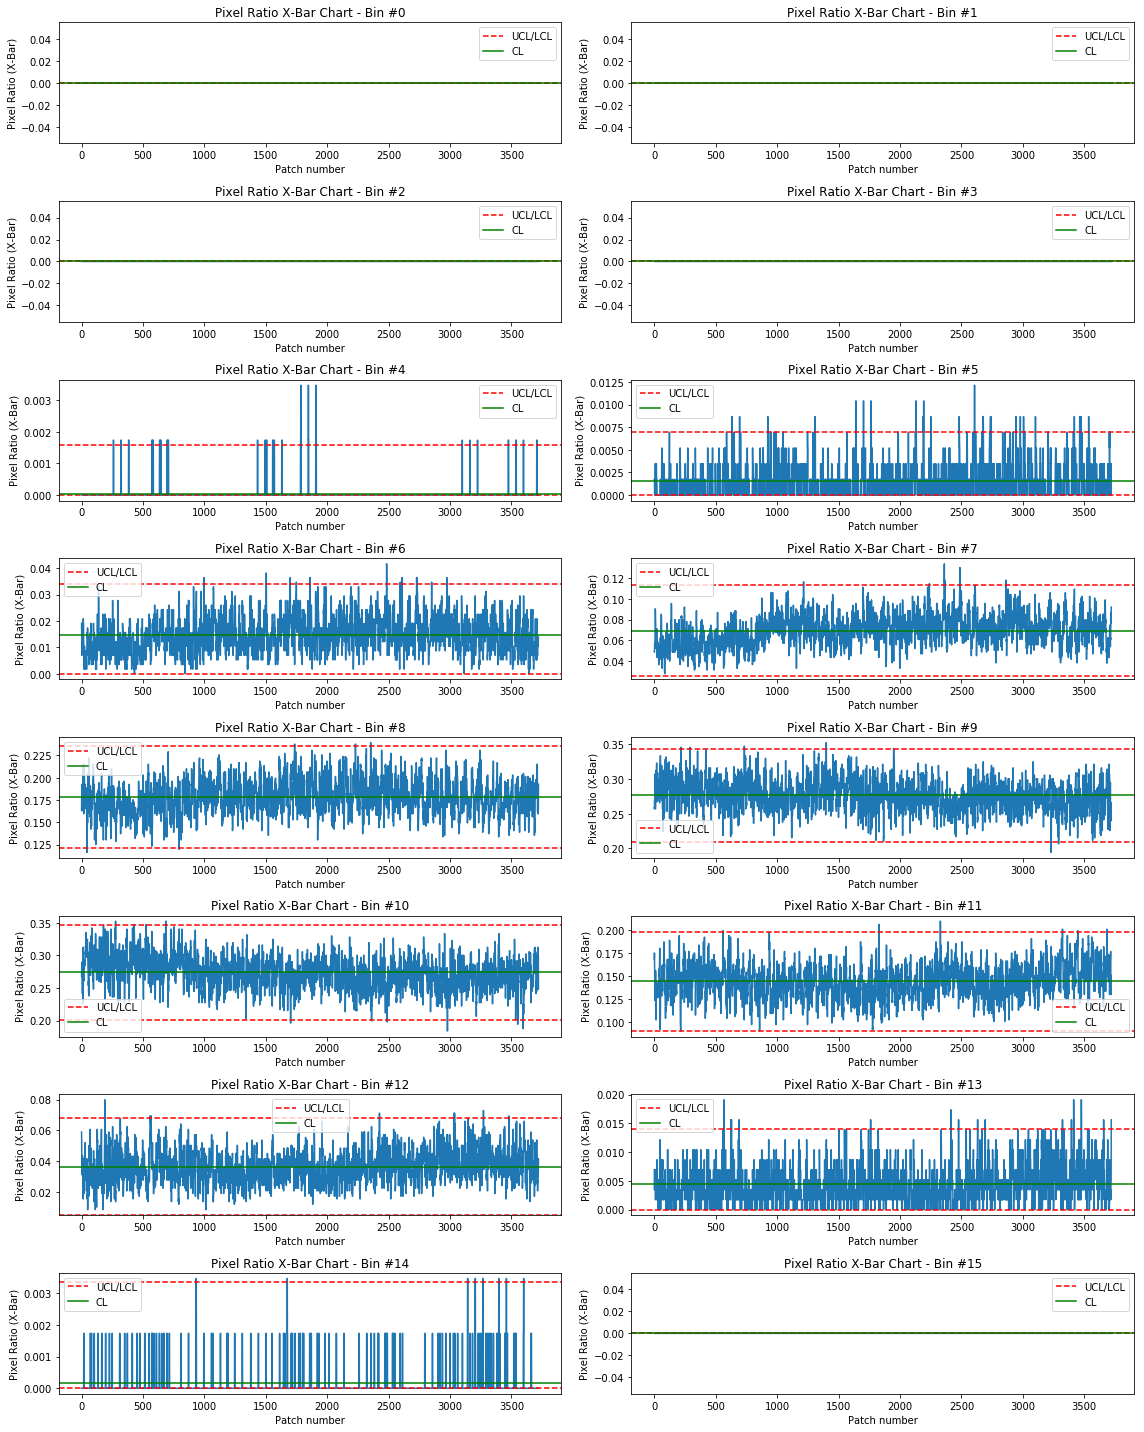

In [361]:
plotXBarChart(patch1_pixel_ratios, image1_bin_limits)

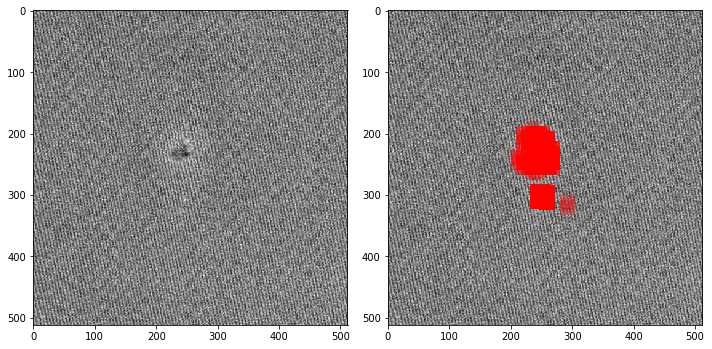

In [732]:
img1 =Image.open("Images/Fabric20.jpg").convert('L')
median_blurred = img1.filter(ImageFilter.MedianFilter(size=3))
not_blurred = np.array(img1)
pix1 = np.array(median_blurred)
patches1 = getPatches(pix1, window_shape, step_length)
patches1.shape
img1_pixel_ratios = getPixelRatios(pix1, bin_number).reshape((-1,))
patch1_pixel_ratios = getPixelRatios(patches1, bin_number)
image1_bin_limits = calculateBinLimits(patch1_pixel_ratios)
outliers = getOutlierPatchIndices(patch1_pixel_ratios, image1_bin_limits, window_shape, step_length,bin_number)
fillOutliers(not_blurred, outliers, window_shape, step_length)

In [676]:
#gaussian_blurred = median_blurred.filter(ImageFilter.GaussianBlur)
#gaussian_blurred = img1.filter(ImageFilter.GaussianBlur)


(3721, 24, 24)

In [678]:
img1_pixel_ratios = getPixelRatios(pix1, bin_number).reshape((-1,))
patch1_pixel_ratios = getPixelRatios(patches1, bin_number)

In [679]:
image1_bin_limits = calculateBinLimits(patch1_pixel_ratios)

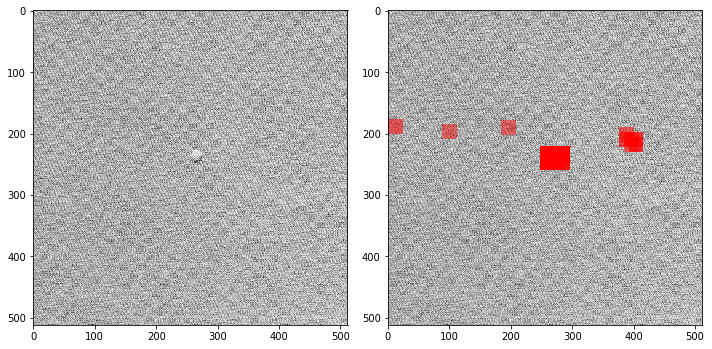

In [680]:
outliers = getOutlierPatchIndices(patch1_pixel_ratios, image1_bin_limits, window_shape, step_length,bin_number)
fillOutliers(not_blurred, outliers, window_shape, step_length)

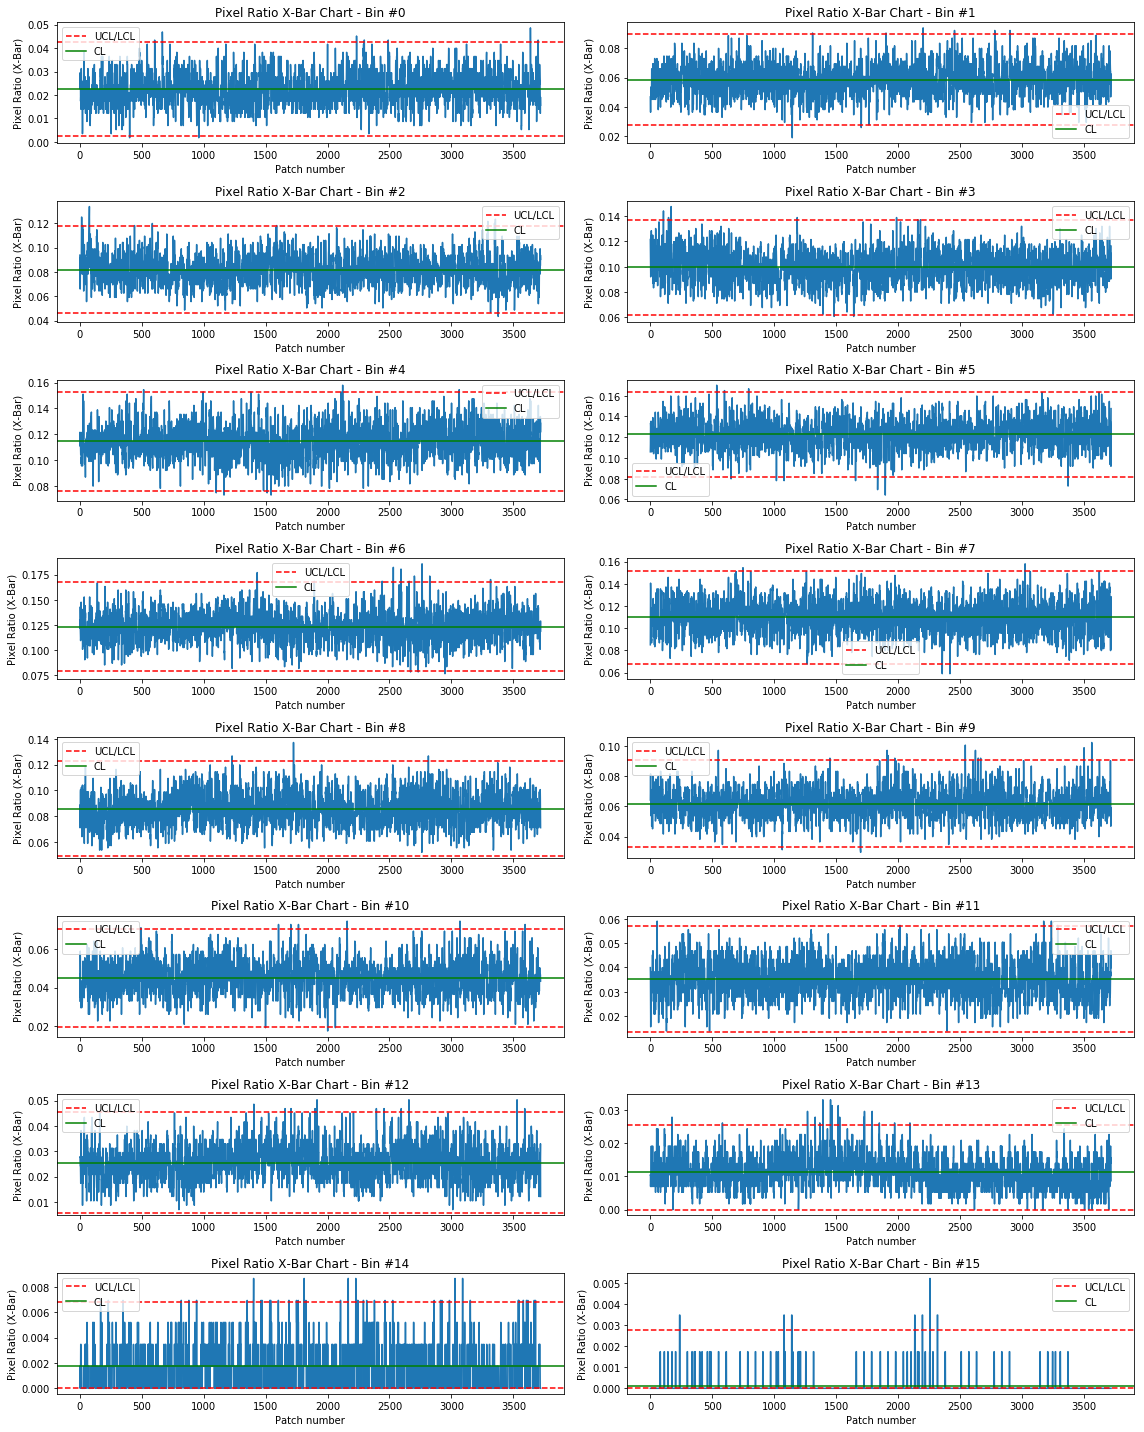

In [426]:
plotXBarChart(patch1_pixel_ratios, image1_bin_limits)

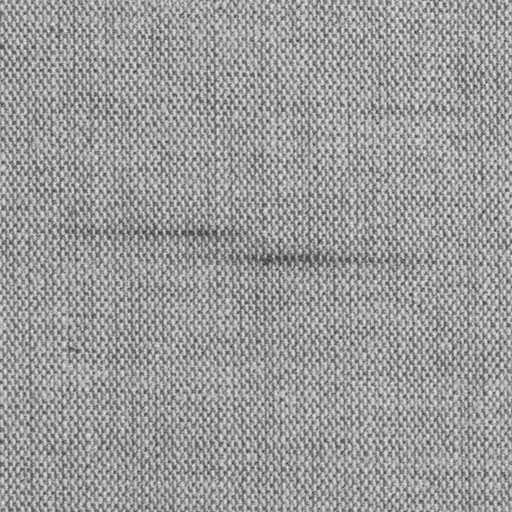

In [22]:
img2 = Image.open("Images/Fabric2.jpg").convert('L')
img2

In [30]:
pix2 = np.array(img2)
patches2 = getPatches(pix2)
img2_pix_ratios = getPixelRatios(pix2).reshape((-1,))
patches2_pix_ratios = getPixelRatios(patches2)

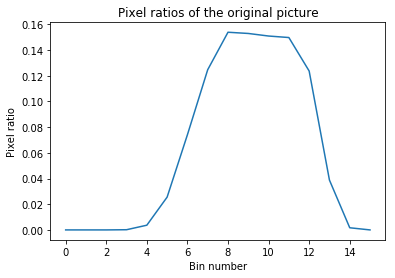

In [31]:
plotPixelRatios(img2_pix_ratios)

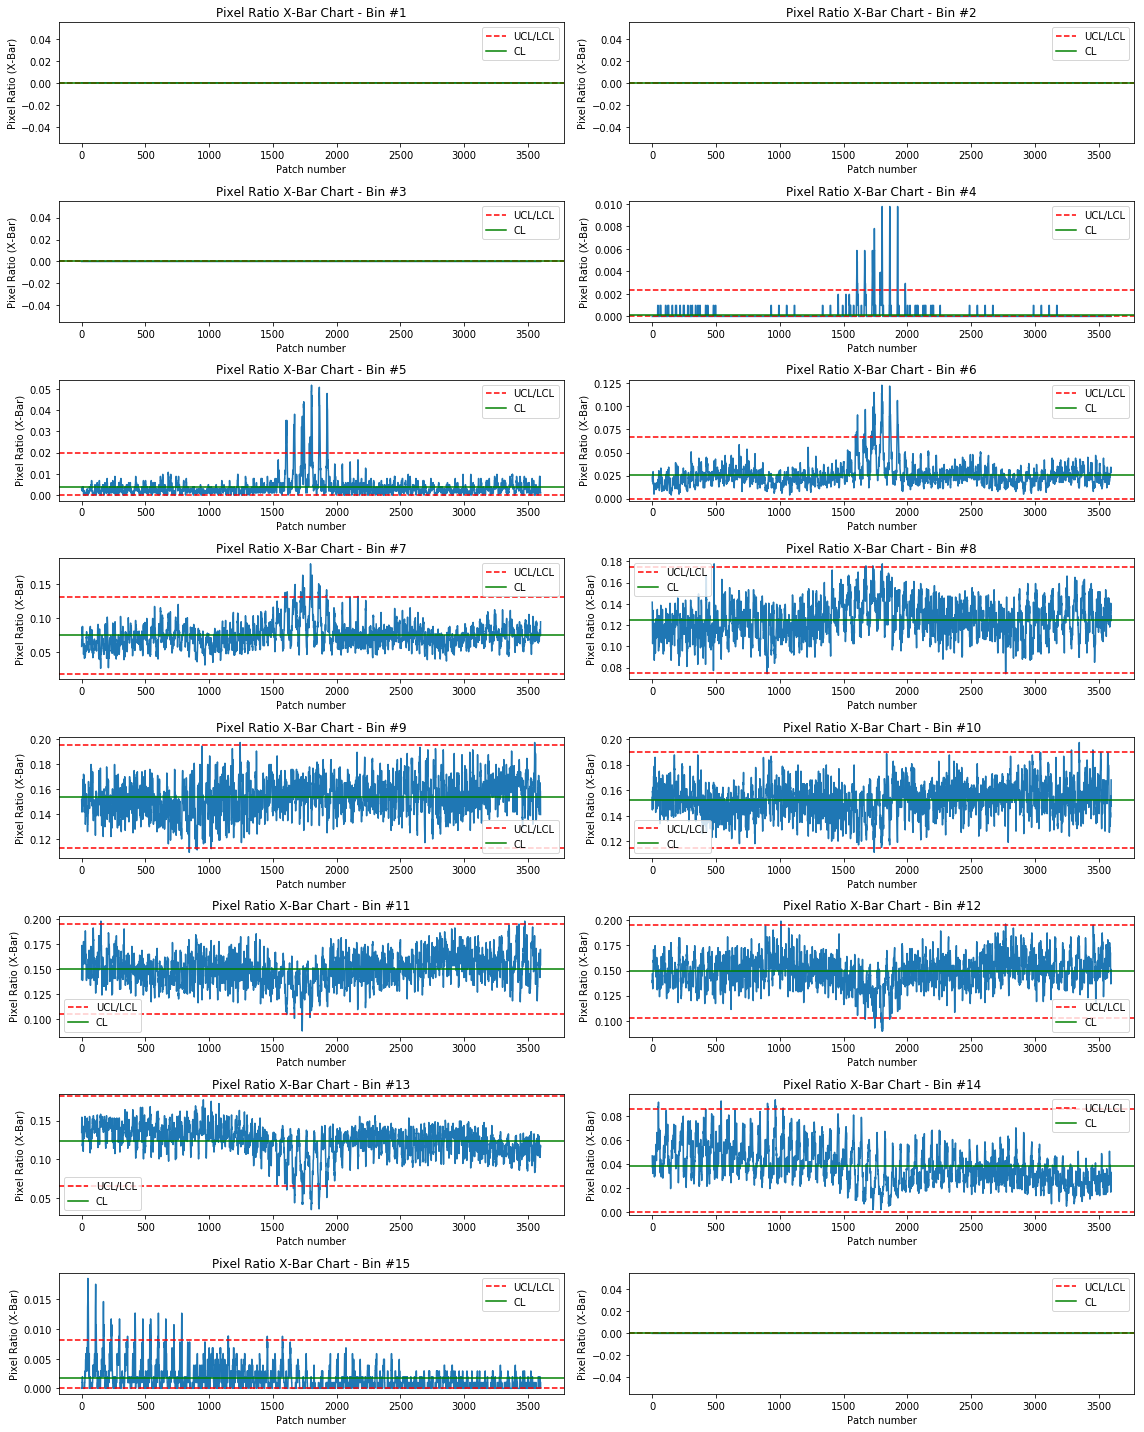

In [32]:
plotXBarChart(patches2_pix_ratios)

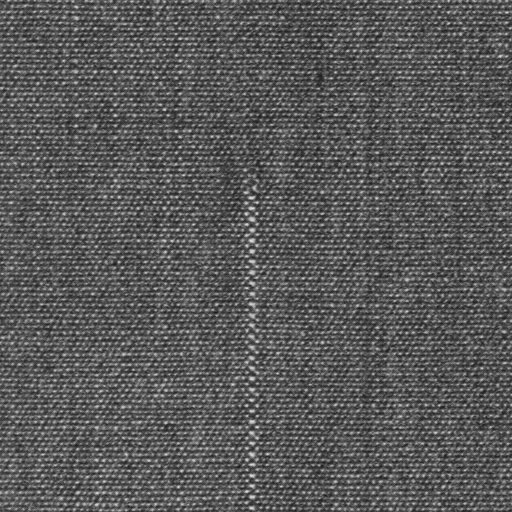

In [40]:
img6 = Image.open("Images/Fabric6.jpg").convert("L")
img6

In [41]:
pix6 = np.array(img6)
patches6 = getPatches(pix6)
img6_pix_ratios = getPixelRatios(pix6).reshape((-1,))
patches6_pix_ratios = getPixelRatios(patches6)

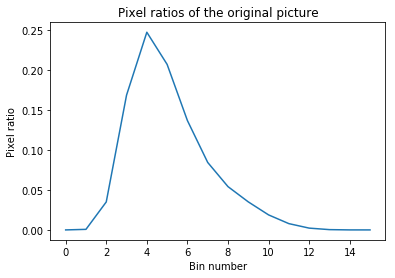

In [42]:
plotPixelRatios(img6_pix_ratios)

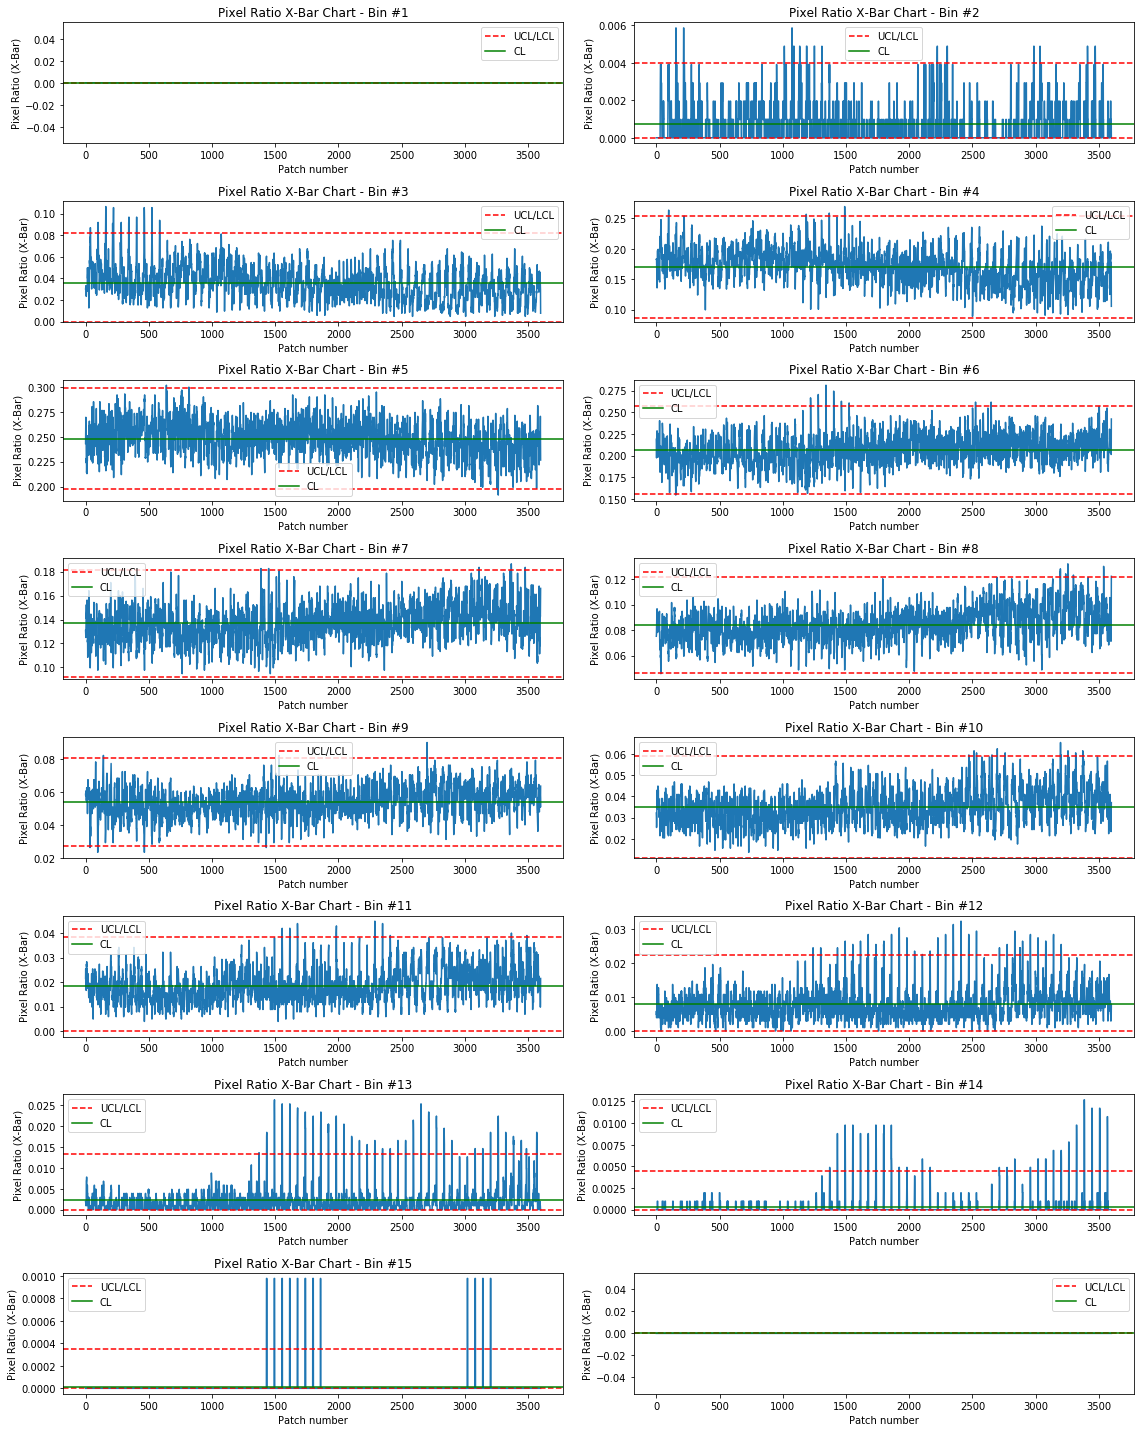

In [43]:
plotXBarChart(patches6_pix_ratios)

## Results

## Conclusions and Future Work

## References

<sup>1</sup> https://textilelearner.blogspot.com/2012/01/linen-fiber-characteristics-of-linen.html

<sup>2</sup> https://www.thespruce.com/definition-of-linen-fabric-1976785

<sup>3</sup> https://www.textilemates.com/textile-testing-quality-control-fibre-testing-fabric-testing-yarn-testing

<sup>4</sup> https://www.almnet.org/page/TestPiece

<sup>5</sup> Jmali Mohamed, Zitouni Baghdadi And Sakli Faouzi " Classification of Fabrics Defects Using Image Analysis and Fuzzy C‐Means Method", International Conference of Applied Research On Textile, Citrat‐6, Hammamet, Tunisia, November 13 – 15, 2014.

<sup>6</sup> Jeong. S, Choi. H, Kim. S, Jaung. J.Y and Kim. S. H (2001): “Detecting Fabric Defects with Computer Vision and Fuzzy Rule Generation. Part I: Defect Classification by Image Processing”, Textile Research Journal, 71(6), pp. 518‐526.

<sup>7</sup> Jeong. S, Choi. H, Kim. S, Jaung. J.Y and Kim. S. H (2001): “Detecting Fabric Defects with Computer Vision and Fuzzy Rule Generation. Part II: Defect Identification by a Fuzzy Expert System”, Textile Research Journal, 71(6), pp. 563‐573.

<sup>8</sup> Blaga Mirela (2009): “Computer Vision Systems for Textiles Quality Control”, The 6th International Conference Management of Technological Changes, Greece, September 2009.

> **NOTE:** The source code is available at [here](https://github.com/BU-IE-582/fall19-akinelden/blob/master/Project_Part3/Part3.ipynb) 